In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

In [2]:

Temperature_data = pd.read_csv("/content/temperature_device_failure.csv", parse_dates=['timestamp'])

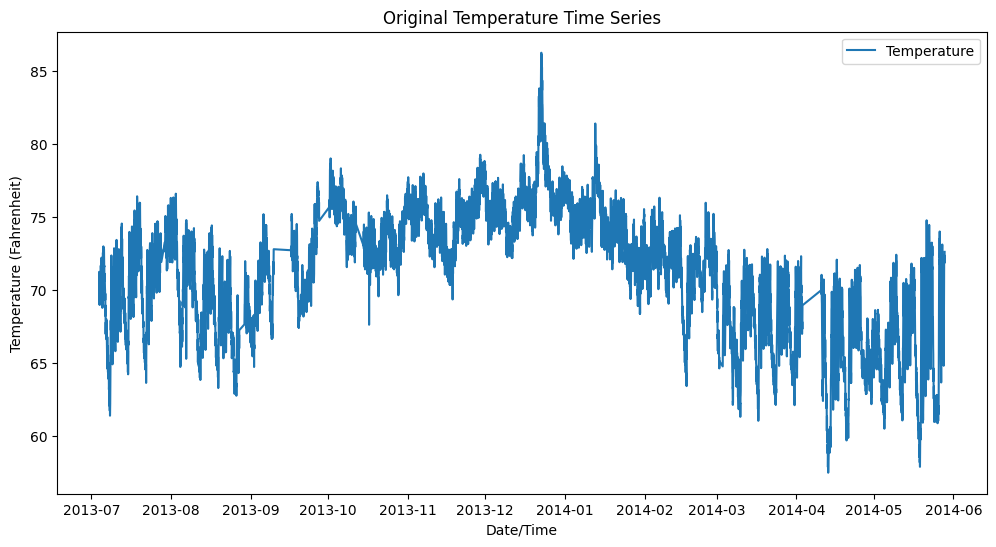

In [3]:
# Time serie plot of the temperature data
plt.figure(figsize=(12, 6))
plt.plot(Temperature_data['timestamp'], Temperature_data['value'], label="Temperature")
plt.xlabel("Date/Time")
plt.ylabel("Temperature (Fahrenheit)")
plt.title("Original Temperature Time Series")
plt.legend()
plt.show()


In [4]:

#  Feature Engineering of the temperature data

Temperature_data['dayofweek'] = Temperature_data['timestamp'].dt.dayofweek
Temperature_data['hours'] = Temperature_data['timestamp'].dt.hour
Temperature_data['day'] = (Temperature_data['hours'] >= 7) & (Temperature_data['hours'] <= 19)
Temperature_data['dtcat'] = np.where((Temperature_data['dayofweek'] < 5) & Temperature_data['day'], 'Weekday Day',
                        np.where((Temperature_data['dayofweek'] < 5) & ~Temperature_data['day'], 'Weekday Night',
                                 np.where((Temperature_data['dayofweek'] >= 5) & Temperature_data['day'], 'Weekend Day', 'Weekend Night')))

In [5]:
Temperature_data.head()

,timestamp,value,dayofweek,hours,day,dtcat
0,2013-07-04 00:00:00,69.880835,3,0,False,Weekday Night
1,2013-07-04 01:00:00,71.220227,3,1,False,Weekday Night
2,2013-07-04 02:00:00,70.877805,3,2,False,Weekday Night
3,2013-07-04 03:00:00,68.959400,3,3,False,Weekday Night
4,2013-07-04 04:00:00,69.283551,3,4,False,Weekday Night


In [6]:
Temperature_data.describe()

,value,dayofweek,hours
count,7267.000000,7267.000000,7267.000000
mean,71.242433,2.988579,11.509289
std,4.247509,1.979945,6.927370
min,57.458406,0.000000,0.000000
25%,68.369411,1.000000,5.500000
50%,71.858493,3.000000,12.000000
75%,74.430958,5.000000,18.000000
max,86.223213,6.000000,23.000000


In [8]:
# checking the null values
Temperature_data.isnull().sum()

timestamp    0
value        0
dayofweek    0
hours        0
day          0
dtcat        0
dtype: int64

In [9]:

#  Apply K-Means for determining the best value for K =2
X = Temperature_data[['dayofweek', 'hours']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
print(X_scaled)

[[ 0.00576899 -1.66153683]
 [ 0.00576899 -1.51717197]
 [ 0.00576899 -1.37280711]
 ...
 [-0.49933023  0.21520635]
 [-0.49933023  0.35957121]
 [-0.49933023  0.50393607]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

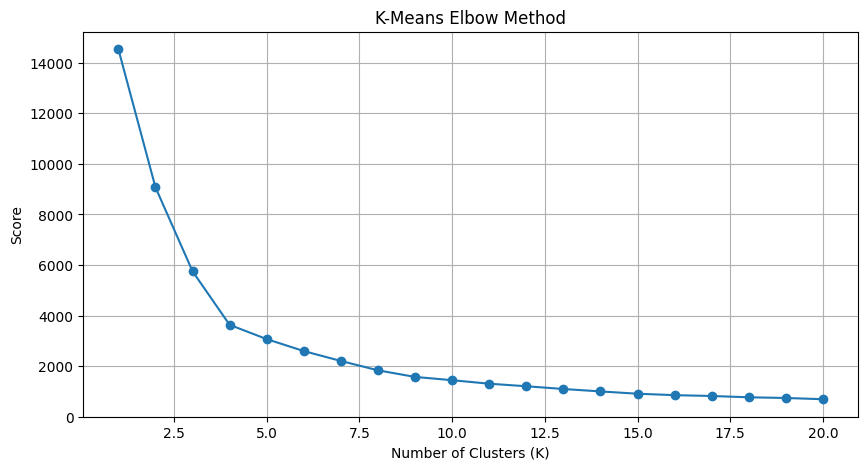

In [11]:

# Determine the best value for K
# Elbow method for best k value
scores = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    scores.append(-kmeans.score(X_scaled))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), scores, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.title("K-Means Elbow Method")
plt.grid()
plt.show()

In [12]:

# Based on the Elbow Method, determine the best value for K ( K=4)
best_k = 4

kmeans = KMeans(n_clusters=best_k, random_state=42)
Temperature_data['cluster'] = kmeans.fit_predict(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
print(Temperature_data['cluster'])

0       2
1       2
2       2
3       2
4       2
       ..
7262    2
7263    3
7264    3
7265    3
7266    3
Name: cluster, Length: 7267, dtype: int32


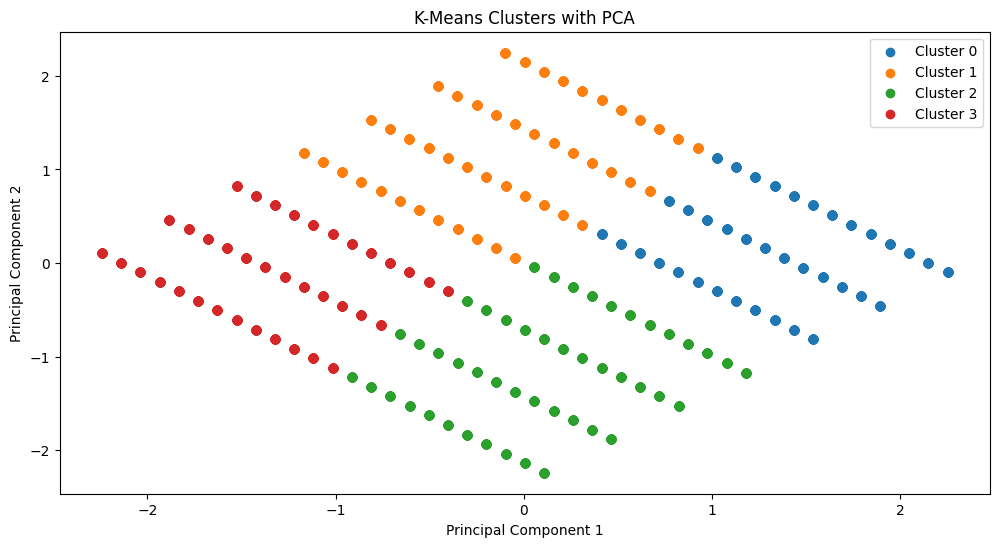

In [14]:

#  Plot K-Means clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(12, 6))
for cluster in range(best_k):
    plt.scatter(X_pca[Temperature_data['cluster'] == cluster, 0], X_pca[Temperature_data['cluster'] == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clusters with PCA")
plt.legend()
plt.show()


In [15]:

#  Apply EllipticEnvelope and Isolation Forest for anomaly detection
def detect_anomalies(model, label):
    Temperature_data[label] = model.fit_predict(X_scaled)
    anomalies = Temperature_data[Temperature_data[label] == -1]
    return anomalies

outliers_fraction = 0.01  # Define the percentage of outliers


In [17]:

# Calculate outliers_fraction using IQR Method
Q1 = Temperature_data['value'].quantile(0.25)

Q3 = Temperature_data['value'].quantile(0.75)

IQR = Q3 - Q1

outliers_fraction_iqr = len(Temperature_data[(Temperature_data['value'] < (Q1 - 1.5 * IQR)) | (Temperature_data['value'] > (Q3 + 1.5 * IQR))]) / len(Temperature_data)


In [18]:
print("Q1 :", Q1)
print("Q3 :",Q3)
print("IQR",IQR)
print("outliers_fraction_iqr : ",outliers_fraction_iqr)

Q1 : 68.36941051
Q3 : 74.43095786
IQR 6.061547350000012
outliers_fraction_iqr :  0.004816292830604101


In [19]:
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt

# Create a function to detect anomalies using EllipticEnvelope and list them
def detect_anomalies_elliptic(model, label, title):
    Temperature_data[label] = model.fit_predict(X_scaled)
    anomalies = Temperature_data[Temperature_data[label] == -1]
    print(f"Anomalies detected in {title}: {len(anomalies)}")



In [20]:
elliptic_envelope = EllipticEnvelope(contamination=outliers_fraction_iqr)
detect_anomalies_elliptic(elliptic_envelope, 'anomalies_elliptic', 'EllipticEnvelope')

Anomalies detected in EllipticEnvelope: 0


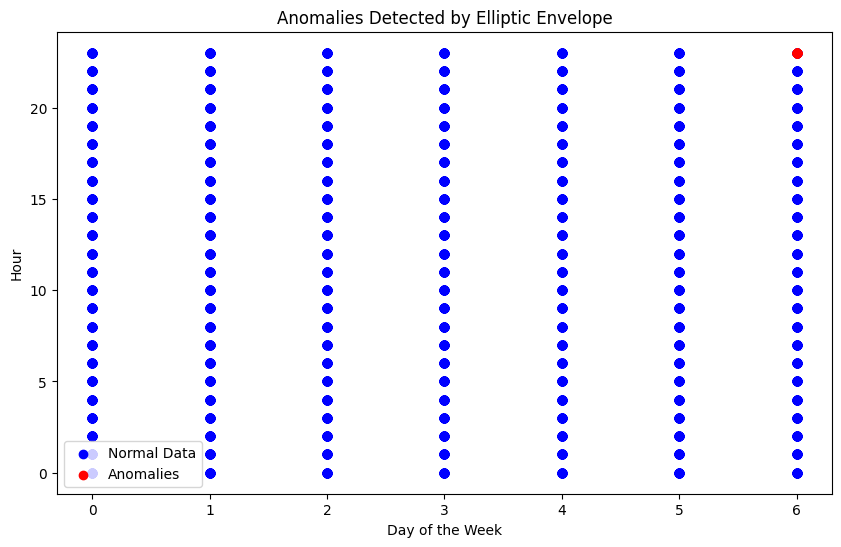

List of anomalies:
               timestamp      value  dayofweek  hours    day          dtcat  \
95   2013-07-07 23:00:00  64.246634          6     23  False  Weekend Night   
263  2013-07-14 23:00:00  65.984710          6     23  False  Weekend Night   
431  2013-07-21 23:00:00  66.338712          6     23  False  Weekend Night   
735  2013-08-04 23:00:00  68.169461          6     23  False  Weekend Night   
903  2013-08-11 23:00:00  64.364588          6     23  False  Weekend Night   
1071 2013-08-18 23:00:00  64.865243          6     23  False  Weekend Night   
1239 2013-08-25 23:00:00  64.389216          6     23  False  Weekend Night   
1360 2013-09-01 23:00:00  68.067626          6     23  False  Weekend Night   
1528 2013-09-08 23:00:00  67.970440          6     23  False  Weekend Night   
1705 2013-09-22 23:00:00  70.444381          6     23  False  Weekend Night   
1946 2013-10-06 23:00:00  76.918417          6     23  False  Weekend Night   
2212 2013-10-20 23:00:00  72.1276

In [21]:
# Assuming you have extracted the day of the week and hour information as 'DayOfWeek' and 'Hour'

envelope = EllipticEnvelope(contamination=0.01)  # Set contamination level


X =Temperature_data[['dayofweek', 'hours']]

# Fit the model
envelope.fit(X)

# Predict anomalies
Temperature_data['anomaly'] = envelope.predict(X)

# Filter anomalies
anomalies = Temperature_data[Temperature_data['anomaly'] == -1]


plt.figure(figsize=(10, 6))
plt.scatter(X['dayofweek'], X['hours'], c='b', label='Normal Data')
plt.scatter(anomalies['dayofweek'], anomalies['hours'], c='r', label='Anomalies')
plt.xlabel('Day of the Week')
plt.ylabel('Hour')
plt.legend()
plt.title('Anomalies Detected by Elliptic Envelope')
plt.show()

# List anomalies
print("List of anomalies:")
print(anomalies)

In [22]:

#  EllipticEnvelope for anomaly detection
envelope = EllipticEnvelope(contamination=outliers_fraction_iqr)
anomalies_envelope = detect_anomalies(envelope, 'anomalies_envelope')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
<ipython-input-23-7654cd372a46>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Anomalies_Isolation'] = isolation_forest.fit_predict(X_subset)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
<ipython-input-23-7654cd372a46>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

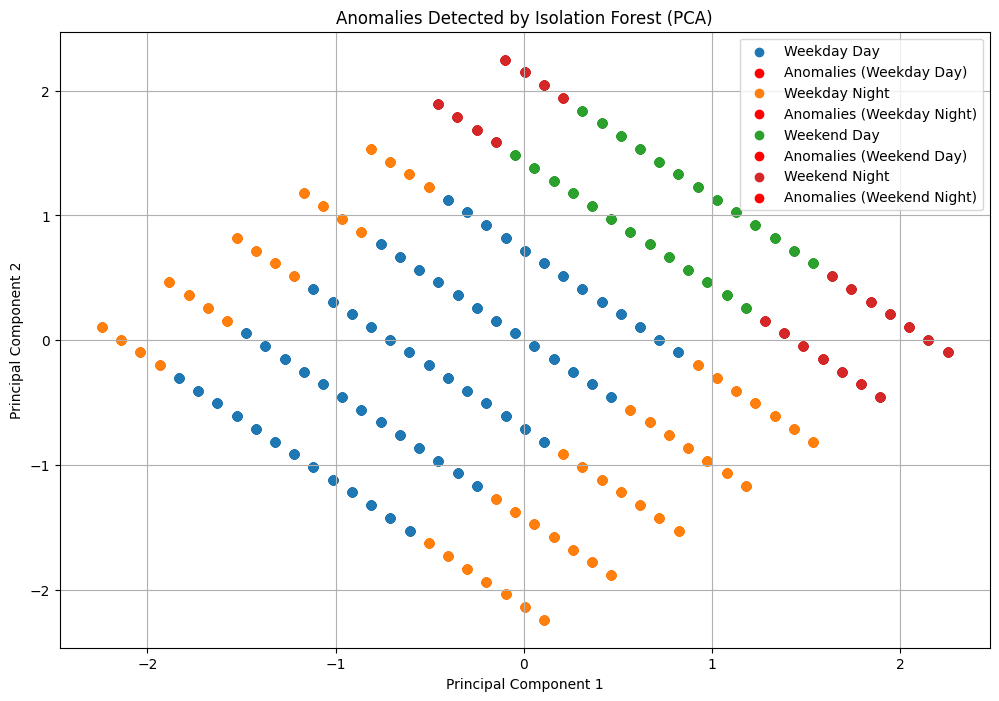

Anomalies detected by Isolation Forest in Weekday Day:
Empty DataFrame
Columns: [timestamp, value, dayofweek, hours, day, dtcat, cluster, anomalies_elliptic, anomaly, anomalies_envelope, Anomalies_Isolation]
Index: []
Anomalies detected by Isolation Forest in Weekday Night:
Empty DataFrame
Columns: [timestamp, value, dayofweek, hours, day, dtcat, cluster, anomalies_elliptic, anomaly, anomalies_envelope, Anomalies_Isolation]
Index: []
Anomalies detected by Isolation Forest in Weekend Day:
Empty DataFrame
Columns: [timestamp, value, dayofweek, hours, day, dtcat, cluster, anomalies_elliptic, anomaly, anomalies_envelope, Anomalies_Isolation]
Index: []
Anomalies detected by Isolation Forest in Weekend Night:
Empty DataFrame
Columns: [timestamp, value, dayofweek, hours, day, dtcat, cluster, anomalies_elliptic, anomaly, anomalies_envelope, Anomalies_Isolation]
Index: []


In [23]:
from sklearn.ensemble import IsolationForest

# Create a dictionary to store anomalies for each category
anomalies_dict = {}

# Define categories
categories = ['Weekday Day', 'Weekday Night', 'Weekend Day', 'Weekend Night']

# Create a figure for plotting
plt.figure(figsize=(12, 8))

# Iterate through categories and apply Isolation Forest
for category in categories:
    # Filter data for the current category
    subset = Temperature_data[Temperature_data['dtcat'] == category]

    # Extract relevant features
    X_subset = subset[['dayofweek', 'hours']]

     # Assuming outliers_fraction is known (e.g., 1%)
    outliers_fraction = 0.01

    # Apply Isolation Forest for anomaly detection
    isolation_forest = IsolationForest(contamination=outliers_fraction, random_state=42)
    subset['Anomalies_Isolation'] = isolation_forest.fit_predict(X_subset)

    # List anomalies for the category
    anomalies_isolation = subset[subset['Anomalies_Isolation'] == -1]
    anomalies_dict[category] = anomalies_isolation

    # Plot anomalies
    plt.scatter(X_pca[subset.index, 0], X_pca[subset.index, 1], label=category)
    plt.scatter(X_pca[anomalies_isolation.index, 0], X_pca[anomalies_isolation.index, 1], c='r', label=f'Anomalies ({category})')

# Set plot labels and legend
plt.title('Anomalies Detected by Isolation Forest (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

# List anomalies for each category
for category, anomalies in anomalies_dict.items():
    print(f"Anomalies detected by Isolation Forest in {category}:")
    print(anomalies)


In [24]:
# Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=outliers_fraction)
anomalies_forest = detect_anomalies(isolation_forest, 'anomalies_forest')

In [27]:
anomalies_forest

,timestamp,value,dayofweek,hours,day,dtcat,cluster,anomalies_elliptic,anomaly,anomalies_envelope,anomalies_forest
95,2013-07-07 23:00:00,64.246634,6,23,False,Weekend Night,1,1,-1,1,-1
263,2013-07-14 23:00:00,65.984710,6,23,False,Weekend Night,1,1,-1,1,-1
431,2013-07-21 23:00:00,66.338712,6,23,False,Weekend Night,1,1,-1,1,-1
735,2013-08-04 23:00:00,68.169461,6,23,False,Weekend Night,1,1,-1,1,-1
903,2013-08-11 23:00:00,64.364588,6,23,False,Weekend Night,1,1,-1,1,-1
1071,2013-08-18 23:00:00,64.865243,6,23,False,Weekend Night,1,1,-1,1,-1
1239,2013-08-25 23:00:00,64.389216,6,23,False,Weekend Night,1,1,-1,1,-1
1360,2013-09-01 23:00:00,68.067626,6,23,False,Weekend Night,1,1,-1,1,-1
1528,2013-09-08 23:00:00,67.970440,6,23,False,Weekend Night,1,1,-1,1,-1
1705,2013-09-22 23:00:00,70.444381,6,23,False,Weekend Night,1,1,-1,1,-1


In [25]:
# Compare the two models for th Anomalies
print(f"EllipticEnvelope found {len(anomalies_envelope)} anomalies.")
print(f"Isolation Forest found {len(anomalies_forest)} anomalies.")

EllipticEnvelope found 0 anomalies.
Isolation Forest found 41 anomalies.
